In [1]:
from yellowbrick.datasets import load_credit
from yellowbrick.features import Rank1D
from yellowbrick.features import Rank2D

import itertools

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score,accuracy_score

from imblearn.datasets import fetch_datasets
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import EasyEnsembleClassifier
from imblearn.ensemble import RUSBoostClassifier

from imblearn.metrics import geometric_mean_score

from sklearn.model_selection import TimeSeriesSplit

from yellowbrick.datasets import load_occupancy
from yellowbrick.target import ClassBalance

C:\Users\hp\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
# Load the dataset
#Dataset wil be uploaded soon...
df_p = pd.read_excel (r'C:\Users\hp\OneDrive - UNSW\Honours student Sai\Vincent\Final_Data\DMV_Crash_Data_Bool.xlsx', skip_header = True)
print((df_p).shape)
print(df_p)


(259, 39)
      Company       Date      Time  Relative speed(mph)  vehicle type  \
0      Delphi 2014-10-14  19:27:00                 28.0           2.0   
1      Google 2015-02-26       NaN                  NaN           3.0   
2      Google 2015-04-07       NaN                  5.0           2.0   
3      Google 2015-04-27  16:27:00                  NaN           3.0   
4      Google 2015-05-30  12:00:00                  1.0           3.0   
..        ...        ...       ...                  ...           ...   
254     Waymo 2020-02-26  12:45:00                 15.0           2.0   
255     Waymo 2020-03-10  07:57:00                  4.0           4.0   
256   Pony.AI 2020-05-30  10:19:00                  NaN           3.0   
257  Cruise   2020-06-01  10:36:00                  NaN           4.0   
258     Waymo 2020-06-15  13:20:00                  2.0           3.0   

    Vehicle make Vehicle model       Road type  Number for Road Type  \
0            NaN           NaN           

In [3]:
filtered_df = (df_p["vehicle type"], df_p["Number for Road Type"], df_p["Intersection"],
    df_p["Intersection Geometry"], df_p["Parking provision"], df_p["Vehicles Involved"], df_p["Mode"],
    df_p["Vehicle1 Status"], df_p["Vehicle2 Status"], df_p["Fault"], df_p["NO. for collision type"],
    df_p["InjuriesBool"], df_p["Vehicle1 Damage"], df_p["Vehicle2 Damage"], df_p["signal"], df_p["Relative speed(mph)"])
df_p = pd.DataFrame(data = filtered_df)
print(type(df_p))
print(df_p.head())
df_p = df_p.transpose()
print(type(df_p))


<class 'pandas.core.frame.DataFrame'>
                       0    1    2    3    4    5    6    7    8    9    ...  \
vehicle type           2.0  3.0  2.0  3.0  3.0  3.0  2.0  3.0  3.0  2.0  ...   
Number for Road Type   2.0  1.0  1.0  1.0  4.0  1.0  1.0  2.0  4.0  1.0  ...   
Intersection           0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...   
Intersection Geometry  2.0  2.0  3.0  3.0  0.0  3.0  3.0  3.0  2.0  2.0  ...   
Parking provision      0.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  1.0  1.0  ...   

                       249  250  251  252  253  254  255  256  257  258  
vehicle type           3.0  4.0  2.0  4.0  2.0  2.0  4.0  3.0  4.0  3.0  
Number for Road Type   2.0  1.0  1.0  1.0  1.0  3.0  1.0  2.0  1.0  1.0  
Intersection           0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  
Intersection Geometry  3.0  2.0  3.0  3.0  3.0  1.0  1.0  3.0  3.0  2.0  
Parking provision      1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  1.0  0.0  

[5 rows x 259 columns]
<class 'panda

In [4]:
#remove Na values

df_R = df_p.dropna(axis=0) #axis=0 
#Determine if rows or columns which contain missing values are removed.
#0, or ‘index’ : Drop rows which contain missing values.
print((df_R).shape)
print(df_R.head())

(68, 16)
   vehicle type  Number for Road Type  Intersection  Intersection Geometry  \
0           2.0                   2.0           0.0                    2.0   
2           2.0                   1.0           1.0                    3.0   
4           3.0                   4.0           1.0                    0.0   
5           3.0                   1.0           1.0                    3.0   
6           2.0                   1.0           1.0                    3.0   

   Parking provision  Vehicles Involved  Mode  Vehicle1 Status  \
0                0.0                2.0   0.0              0.0   
2                1.0                2.0   1.0              1.0   
4                1.0                2.0   1.0              0.0   
5                1.0                2.0   1.0              0.0   
6                1.0                2.0   1.0              0.0   

   Vehicle2 Status  Fault  NO. for collision type  InjuriesBool  \
0              1.0    0.0                     2.0         

In [5]:
X_df = (df_R["vehicle type"], df_R["Number for Road Type"], df_R["Intersection"],
    df_R["Intersection Geometry"], df_R["Parking provision"], df_R["Vehicles Involved"], df_R["Mode"],
    df_R["Vehicle1 Status"], df_R["Vehicle2 Status"], df_R["Fault"], df_R["NO. for collision type"],
    df_R["Vehicle1 Damage"], df_R["Vehicle2 Damage"], df_R["signal"],df_R["Relative speed(mph)"])
print(type(X_df))
print(len(X_df))
X_np= np.asarray(X_df)
print(type(X_np))
print((X_np).shape)
X_np= np.transpose(X_df)
print(type(X_np))
print((X_np).shape)

<class 'tuple'>
15
<class 'numpy.ndarray'>
(15, 68)
<class 'numpy.ndarray'>
(68, 15)


In [6]:
#Please enter the dependent variables
Y_df = (df_R["InjuriesBool"])
print(type(Y_df))
print(len(Y_df))
Y_np= np.asarray(Y_df)
print(type(Y_np))
print((Y_np).shape)
Y_np= np.transpose(Y_df)
print(type(Y_np))
print((Y_np).shape)

<class 'pandas.core.series.Series'>
68
<class 'numpy.ndarray'>
(68,)
<class 'pandas.core.series.Series'>
(68,)


In [7]:
my_features = ["vehicle type","Number for Road Type","Intersection","Intersection Geometry","Parking provision","Vehicles Involved","Mode",
    "Vehicle1 Status", "Vehicle2 Status", "Fault","NO. for collision type",
    "Vehicle1 Damage", "Vehicle2 Damage", "signal","Relative speed"]

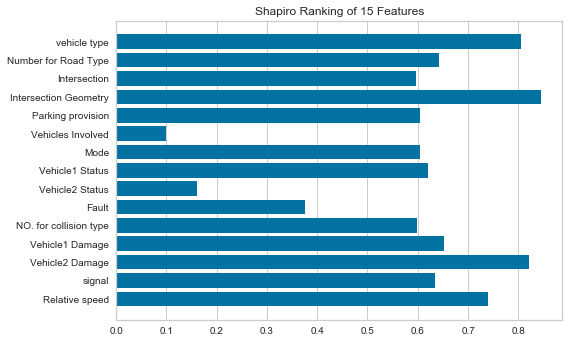

In [8]:

# Create a list of the features to plot

# Instantiate the 1D visualizer with the Sharpiro ranking algorithm
visualizer = Rank1D(algorithm='shapiro', features = my_features, sort=True)

visualizer.fit(X_np, Y_np)           # Fit the data to the visualizer
visualizer.transform(X_np)        # Transform the data
visualizer.show() 

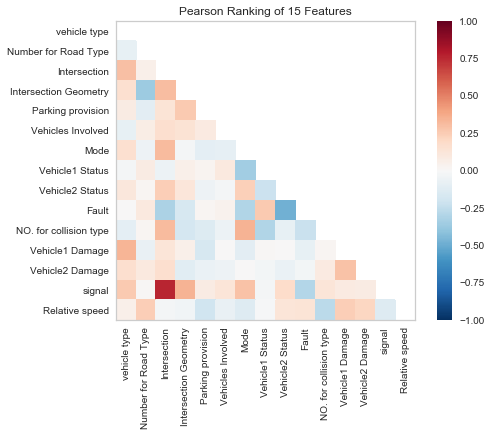

In [9]:
# Instantiate the visualizer with the covariance ranking algorithm
visualizer = Rank2D(algorithm='pearson', features = my_features, sort=True)
#visualizer = Rank2D(algorithm='covariance', features = my_features, sort=True)

visualizer.fit(X_np, Y_np)           # Fit the data to the visualizer
visualizer.transform(X_np)        # Transform the data
visualizer.show()              # Finalize and render the figure

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_np, Y_np, 
                                                    test_size=0.20, 
                                                    random_state=42, stratify = Y_np)

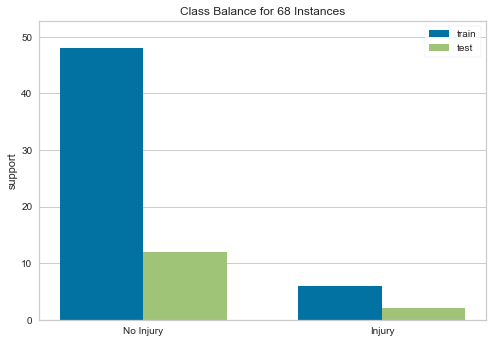

In [11]:
# Instantiate the visualizer
visualizer = ClassBalance(labels=["No Injury", "Injury"])

visualizer.fit(y_train, y_test)        # Fit the data to the visualizer
visualizer.show()                      # Finalize and render the figure

In [12]:
%matplotlib inline
import numpy as np
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.distributions.mixture_rvs import mixture_rvs
import seaborn as sns
#KDE


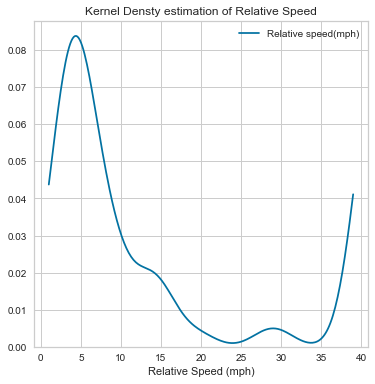

In [13]:
#Plotting Kernel Density Estimation for Relative velocity
X=df_R["Relative speed(mph)"]
fig, ax = plt.subplots(figsize=(6,6))
sns.kdeplot(X,clip=(0,100), gridsize = 200,cut=0)



ax.set_title('Kernel Densty estimation of Relative Speed')

ax.set_xlabel('Relative Speed (mph)')

plt.show()


In [14]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, classes, ax,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    print(cm)
    print('')

    ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.sca(ax)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

    ax.set_ylabel('Predicted label')
    ax.set_xlabel('True label')
my_class = ["No injury",  "Injury"]

In [15]:
from sklearn.linear_model import LogisticRegressionCV

clf = LogisticRegressionCV(cv=5, random_state=0).fit(X_train, y_train)

y_pred = clf.predict(X_test)
#, X_test, , y_test

#clf.score(y_test,y_pred)


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressio

LogisticRegressionCV
Balanced accuracy: 0.50 - Geometric mean 0.00
F1 Score: 0.0
[[12  0]
 [ 2  0]]



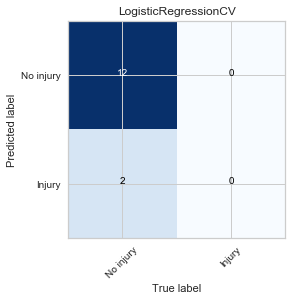

In [16]:
print('LogisticRegressionCV')
print('Balanced accuracy: {:.2f} - Geometric mean {:.2f}'
      .format(balanced_accuracy_score(y_test, y_pred),
              geometric_mean_score(y_test, y_pred)))
print("F1 Score: " + str(f1_score(y_test,y_pred)))
cm_rf = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(ncols=1)
plot_confusion_matrix(cm_rf, classes=my_class, ax=ax,
                      title='LogisticRegressionCV')


In [17]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0, penalty = 'l2', solver = "liblinear")#, class_weight = 'balanced')#class_weight = 'balanced')
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
#, X_test, , y_test

#clf.score(y_test,y_pred)


LogisticRegression classifier performance
Balanced accuracy: 0.46 - Geometric mean 0.00
F1 Score: 0.0
[[11  1]
 [ 2  0]]



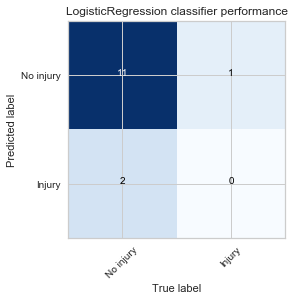

In [18]:
print('LogisticRegression classifier performance')
print('Balanced accuracy: {:.2f} - Geometric mean {:.2f}'
      .format(balanced_accuracy_score(y_test, y_pred),
              geometric_mean_score(y_test, y_pred)))
print("F1 Score: " + str(f1_score(y_test,y_pred)))
cm_rf = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(ncols=1)
plot_confusion_matrix(cm_rf, classes=my_class, ax=ax,
                      title='LogisticRegression classifier performance')


In [19]:
#New training set based on feature importance ranks
X_df = (df_R["vehicle type"], df_R["Number for Road Type"], df_R["Intersection"],
    df_R["Intersection Geometry"], df_R["Parking provision"], df_R["Mode"],
    df_R["Vehicle1 Status"],
    df_R["Vehicle1 Damage"], df_R["Vehicle2 Damage"], df_R["signal"],df_R["Relative speed(mph)"])
print(type(X_df))
print(len(X_df))
X_np= np.asarray(X_df)
print(type(X_np))
print((X_np).shape)
X_np= np.transpose(X_df)
print(type(X_np))
print((X_np).shape)

<class 'tuple'>
11
<class 'numpy.ndarray'>
(11, 68)
<class 'numpy.ndarray'>
(68, 11)


In [20]:
#Splitting the training and testing data
X_train, X_test, y_train, y_test = train_test_split(X_np, Y_np, 
                                                    test_size=0.20, 
                                                    random_state=42, stratify = Y_np)

# LogisticRegression

Logistic Regression classifier performance
Balanced accuracy: 0.46 - Geometric mean 0.00
F1 Score: 0.0
[[11  1]
 [ 2  0]]



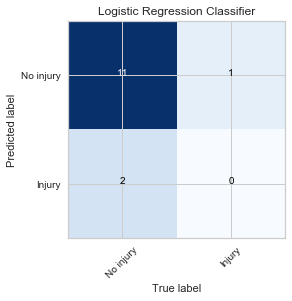

In [21]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0, penalty = 'l2', solver = "liblinear")#, class_weight = 'balanced')#class_weight = 'balanced')
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print('Logistic Regression classifier performance')
print('Balanced accuracy: {:.2f} - Geometric mean {:.2f}'
      .format(balanced_accuracy_score(y_test, y_pred),
              geometric_mean_score(y_test, y_pred)))
print("F1 Score: " + str(f1_score(y_test,y_pred)))
cm_rf = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(ncols=1)
plot_confusion_matrix(cm_rf, classes=my_class, ax=ax,
                      title='Logistic Regression Classifier')


C:\Users\hp\anaconda3\lib\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
C:\Users\hp\anaconda3\lib\site-packages\yellowbrick\model_selection\importances.py:195: YellowbrickWarning: detected multi-dimensional feature importances but stack=False, using mean to aggregate them.
  YellowbrickWarning,


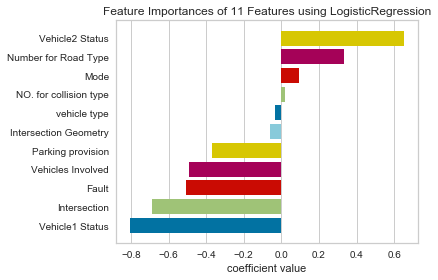

In [22]:
from yellowbrick.datasets import load_occupancy
from yellowbrick.model_selection import FeatureImportances

#model = RandomForestClassifier(n_estimators=10)
viz = FeatureImportances(clf, labels=my_features, relative=False)
viz.fit(X_np, Y_np)
viz.show()

C:\Users\hp\anaconda3\lib\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


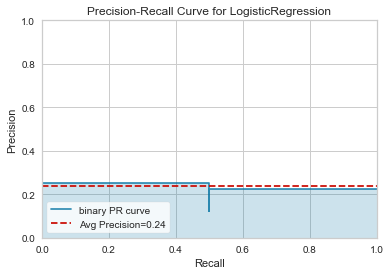

In [23]:
#Precision Recall curve
import matplotlib.pyplot as plt

from yellowbrick.datasets import load_spam
from sklearn.linear_model import RidgeClassifier
from yellowbrick.classifier import PrecisionRecallCurve
from sklearn.model_selection import train_test_split as tts

# Create the visualizer, fit, score, and show it
viz = PrecisionRecallCurve(clf)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.show()

# LogisticRegressionCV

Logistic Regression classifier performance: with weigths
Balanced accuracy: 0.50 - Geometric mean 0.00
F1 Score: 0.0
[[12  0]
 [ 2  0]]



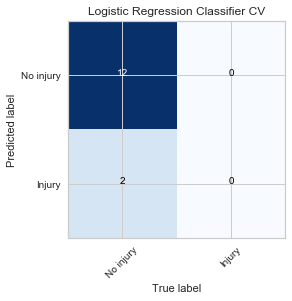

In [24]:
from sklearn.linear_model import LogisticRegressionCV

clf = LogisticRegressionCV(random_state=0, penalty = 'l2', solver = "liblinear")#, class_weight = 'balanced')#class_weight = 'balanced')
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print('Logistic Regression classifier performance: with weigths')
print('Balanced accuracy: {:.2f} - Geometric mean {:.2f}'
      .format(balanced_accuracy_score(y_test, y_pred),
              geometric_mean_score(y_test, y_pred)))
print("F1 Score: " + str(f1_score(y_test,y_pred)))
cm_rf = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(ncols=1)
plot_confusion_matrix(cm_rf, classes=my_class, ax=ax,
                      title='Logistic Regression Classifier CV')


# SGDClassifier

In [25]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Always scale the input. The most convenient way is to use a pipeline.
clf = make_pipeline(StandardScaler(),
                    SGDClassifier(max_iter=1000, tol=1e-3, loss = 'perceptron'))
clf.fit(X_train, y_train)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdclassifier', SGDClassifier(loss='perceptron'))])

SGDClassifier with loss = perceptron
Balanced accuracy: 0.38 - Geometric mean 0.00
F1 Score: 0.0
[[9 3]
 [2 0]]



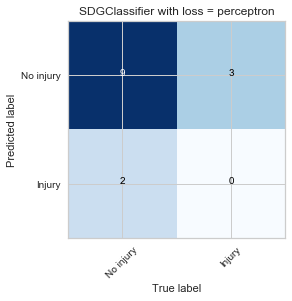

In [27]:
y_pred = clf.predict(X_test)
print('SGDClassifier with loss = perceptron')
print('Balanced accuracy: {:.2f} - Geometric mean {:.2f}'
      .format(balanced_accuracy_score(y_test, y_pred),
              geometric_mean_score(y_test, y_pred)))
print("F1 Score: " + str(f1_score(y_test,y_pred)))
cm_rf = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(ncols=1)
plot_confusion_matrix(cm_rf, classes=my_class, ax=ax,
                      title='SDGClassifier with loss = perceptron')
